In [1]:
import os
import time

import numpy as np
import torch
from torch import nn
from accelerate import Accelerator
from spender import SpectrumAutoencoder
from spender.data import desi_qso as desi 
from spender.util import mem_report

In [17]:
# --- plotting --- 
import corner as DFM
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rcParams['text.usetex'] = True
mpl.rcParams['font.family'] = 'serif'
mpl.rcParams['axes.linewidth'] = 1.5
mpl.rcParams['axes.xmargin'] = 1
mpl.rcParams['xtick.labelsize'] = 'x-large'
mpl.rcParams['xtick.major.size'] = 5
mpl.rcParams['xtick.major.width'] = 1.5
mpl.rcParams['ytick.labelsize'] = 'x-large'
mpl.rcParams['ytick.major.size'] = 5
mpl.rcParams['ytick.major.width'] = 1.5
mpl.rcParams['legend.frameon'] = False

In [2]:
print("torch.cuda.device_count():",torch.cuda.device_count())

torch.cuda.device_count(): 1


In [3]:
def load_model(filename, models, instruments):
    device = instruments[0].wave_obs.device
    model_struct = torch.load(filename, map_location=device)
    #wave_rest = model_struct['model'][0]['decoder.wave_rest']
    
    for i, model in enumerate(models):
        # backwards compat: encoder.mlp instead of encoder.mlp.mlp
        if 'encoder.mlp.mlp.0.weight' in model_struct['model'][i].keys():
            from collections import OrderedDict
            model_struct['model'][i] = OrderedDict([(k.replace('mlp.mlp', 'mlp'), v) for k, v in model_struct['model'][i].items()])
        # backwards compat: add instrument to encoder
        try:
            model.load_state_dict(model_struct['model'][i], strict=False)
        except RuntimeError:
            model_struct['model'][i]['encoder.instrument.wave_obs']= instruments[i].wave_obs
            #model_struct['model'][i]['encoder.instrument.skyline_mask']= instruments[i].skyline_mask
            model.load_state_dict(model_struct[i]['model'], strict=False)

    losses = model_struct['losses']
    return models, losses

In [4]:
# define instruments
instruments = [ desi.DESI() ]

# data loaders
batch_size = 64
_dir = '/tigress/chhahn/spender_qso/train'
#trainloaders = [ inst.get_data_loader(_dir, tag="qso_lowz", which="train",  batch_size=batch_size, shuffle=True, shuffle_instance=True) for inst in instruments ]
validloaders = [ inst.get_data_loader(_dir,  tag="qso_lowz", which="valid", batch_size=batch_size, shuffle=True, shuffle_instance=True) for inst in instruments ]

In [5]:
latents = 10 
z_max = 2.1

# restframe wavelength for reconstructed spectra
# Note: represents joint dataset wavelength range
lmbda_min = instruments[0].wave_obs[0]/(1.0+z_max) # 2000 A
lmbda_max = instruments[0].wave_obs[-1] # 9824 A
bins = 9780
wave_rest = torch.linspace(lmbda_min, lmbda_max, bins, dtype=torch.float32)

# define and train the model
n_hidden = (64, 256, 1024)
models = [ SpectrumAutoencoder(instrument,
                               wave_rest,
                               n_latent=latents,
                               n_hidden=n_hidden,
                               act=[nn.LeakyReLU()]*(len(n_hidden)+1)
                               )
          for instrument in instruments ]

In [6]:
models, losses = load_model('/tigress/chhahn/spender_qso/train/testing.pt', models, instruments)

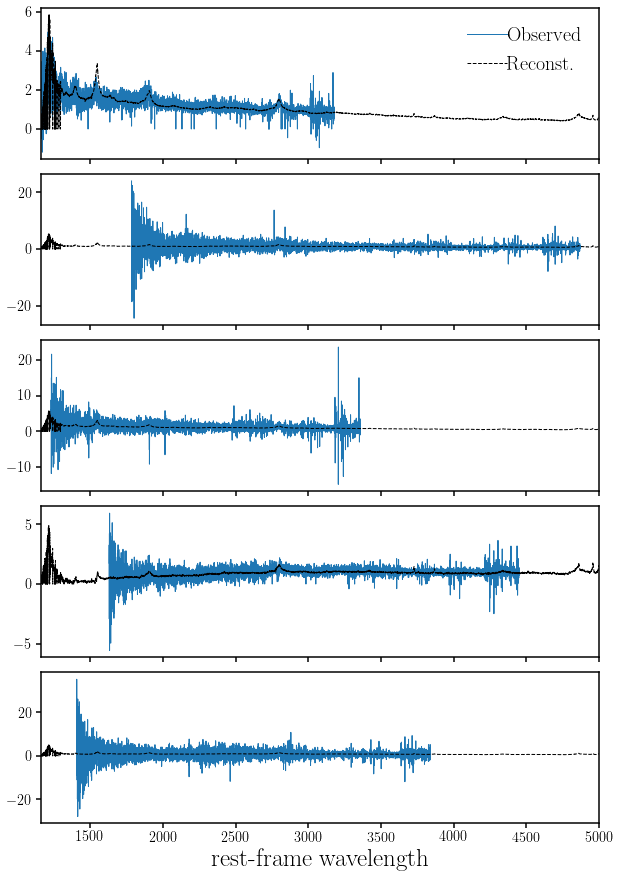

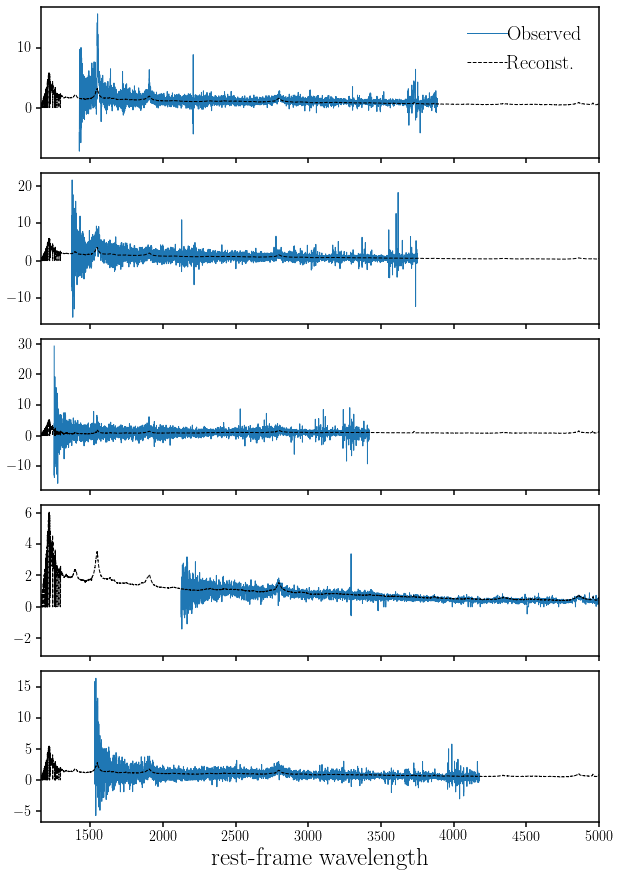

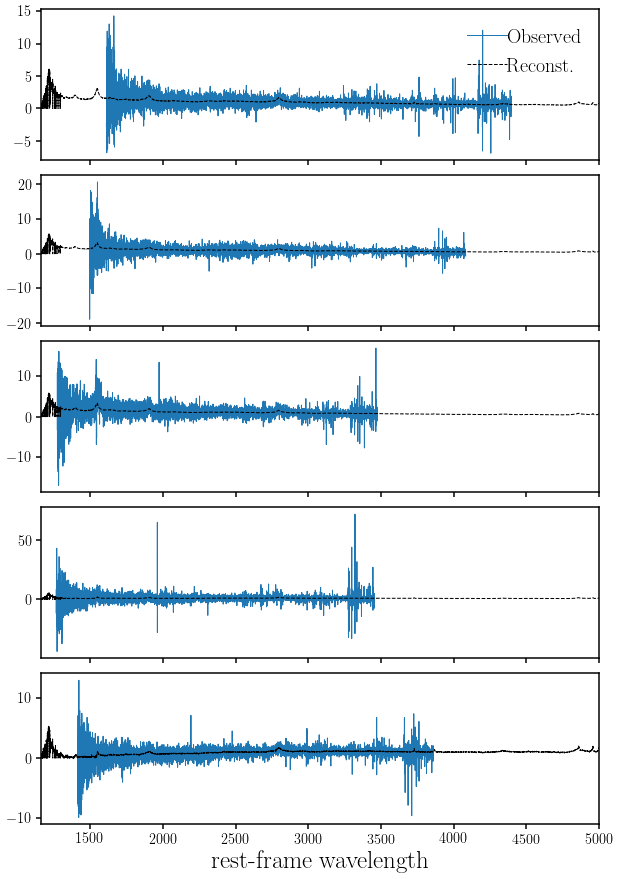

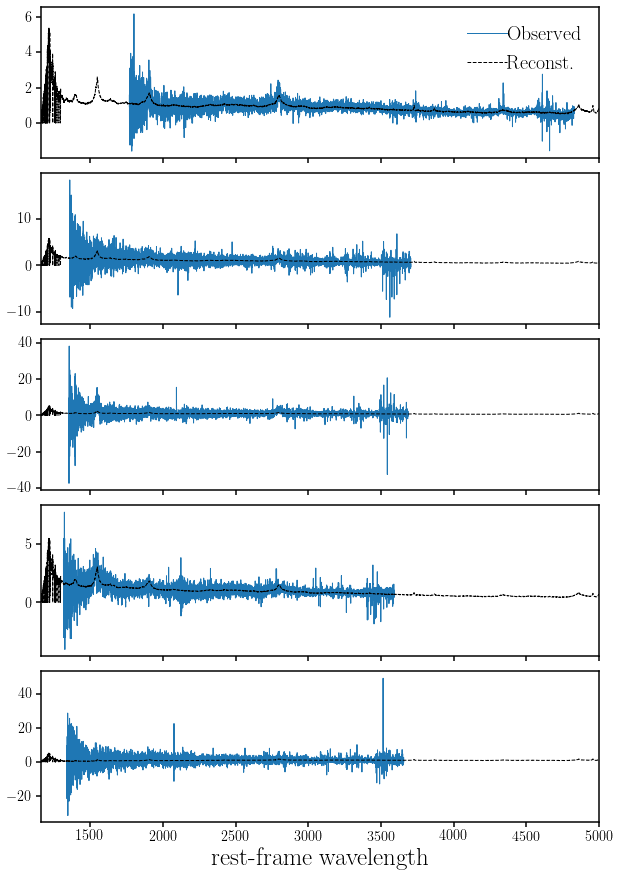

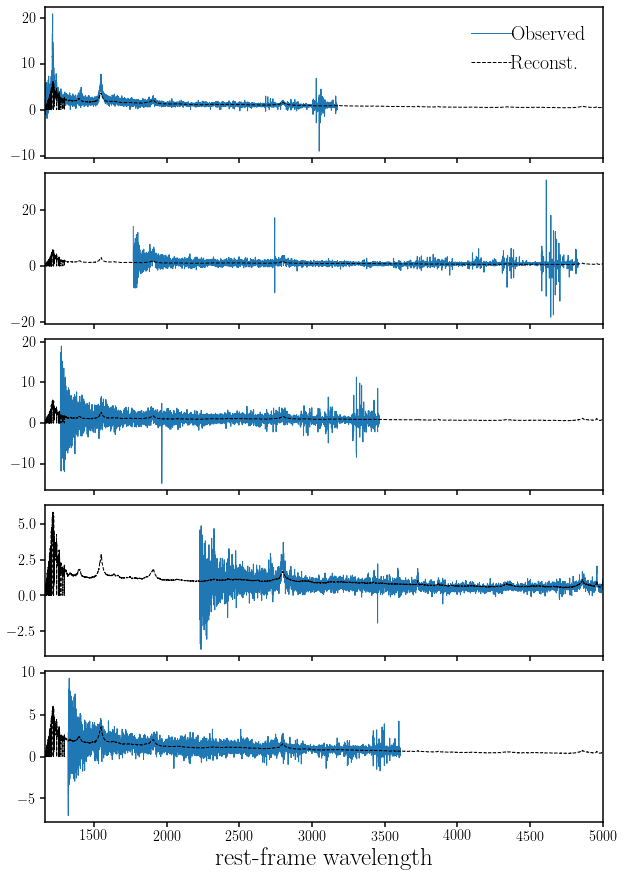

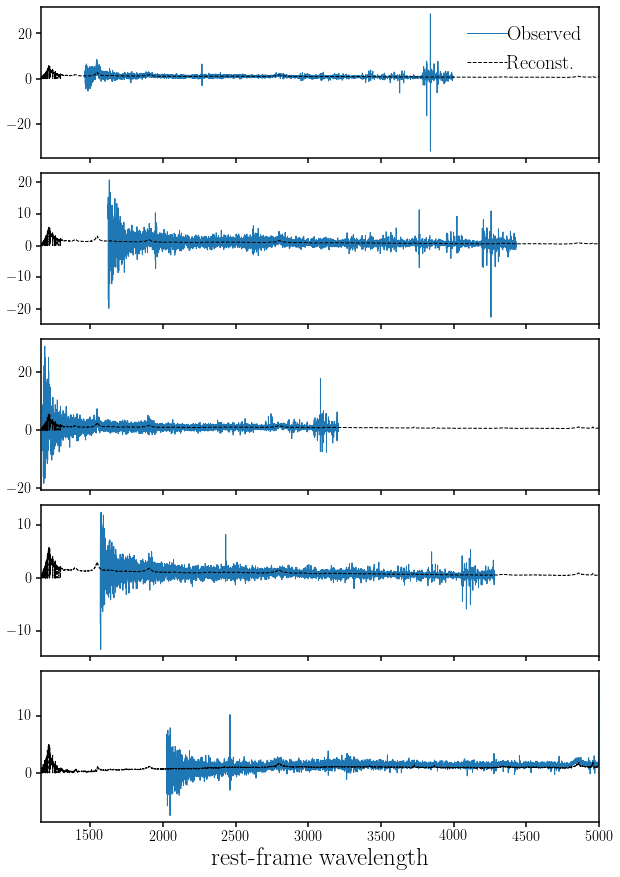

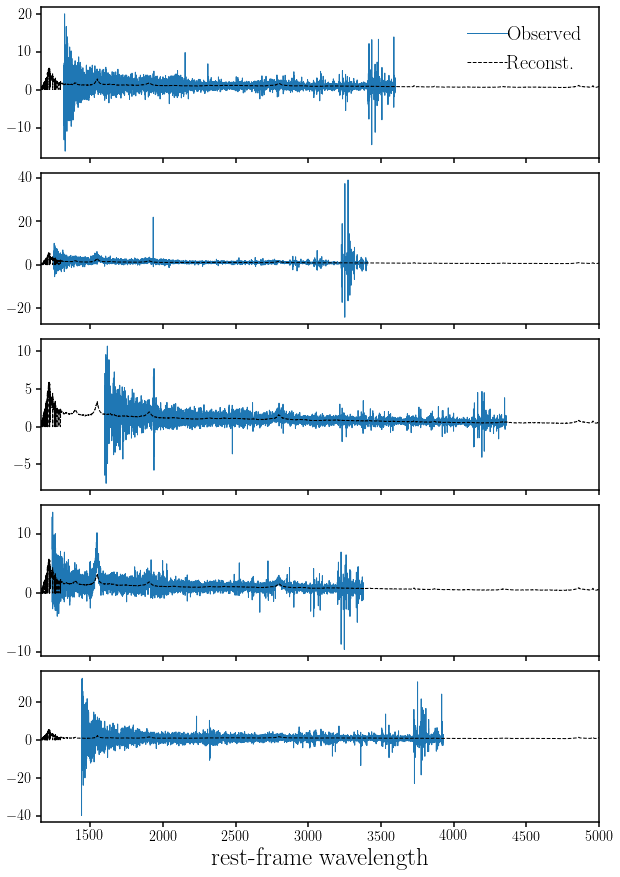

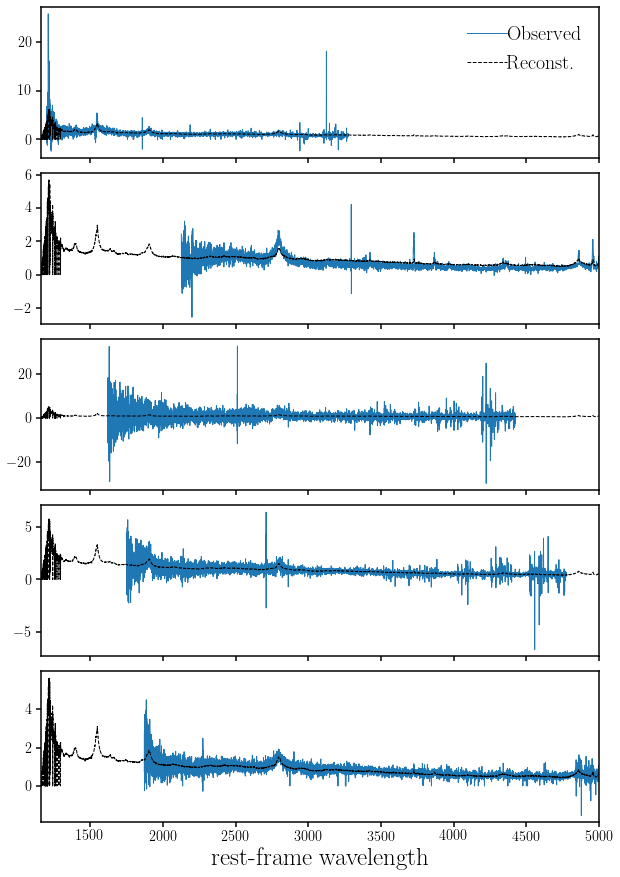

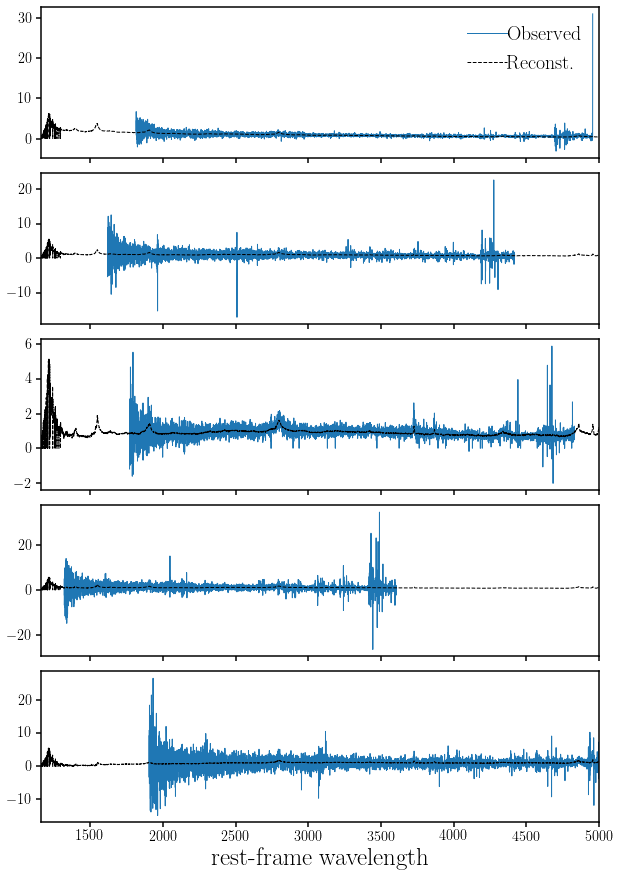

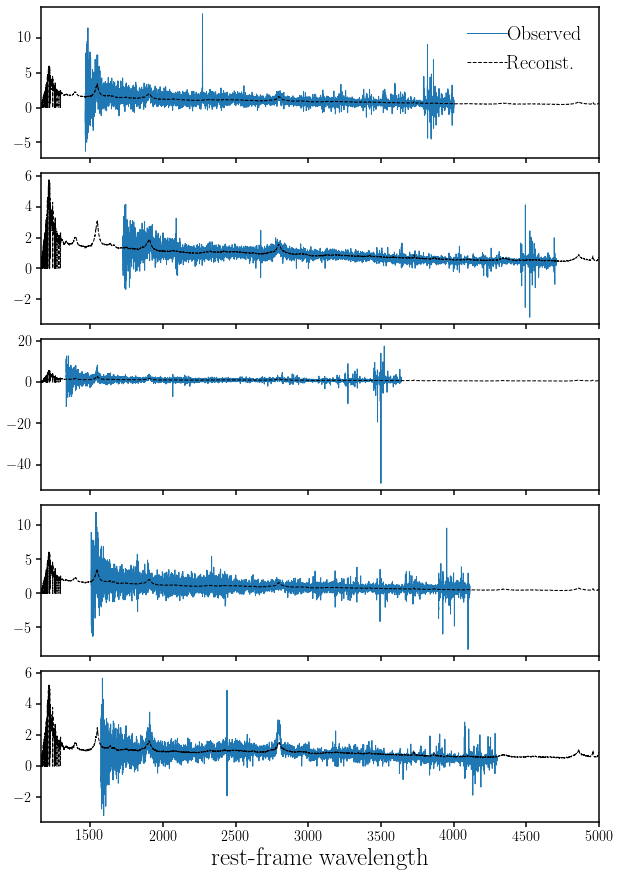

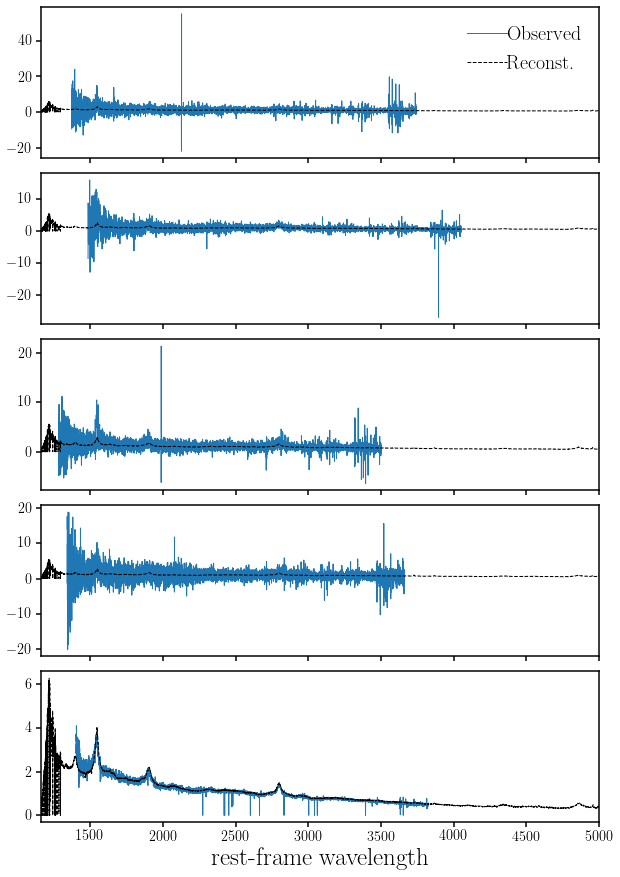

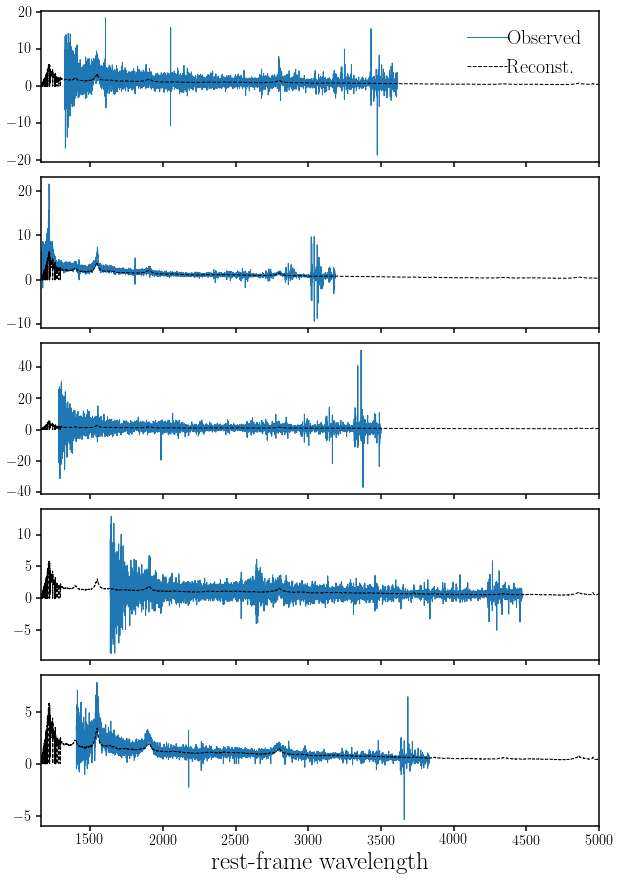

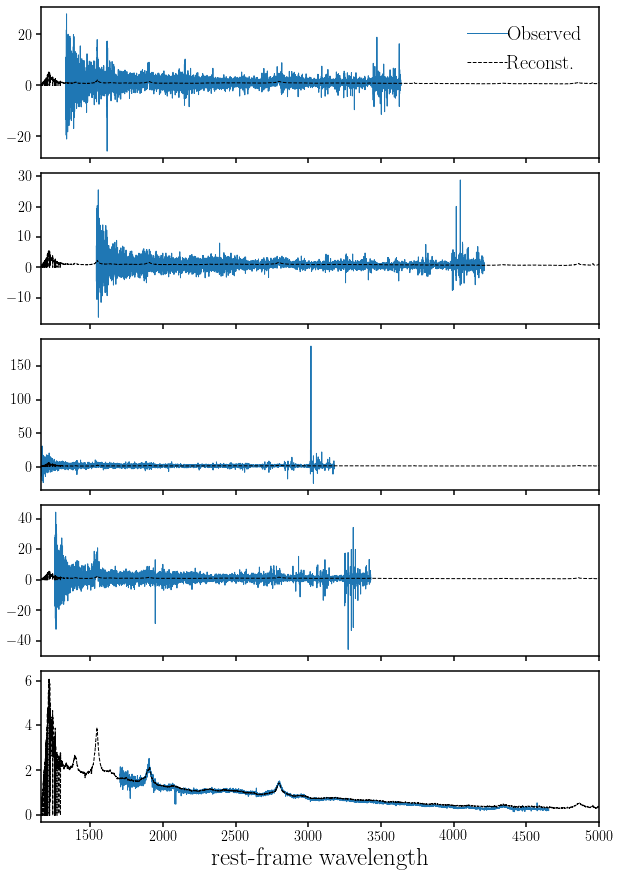

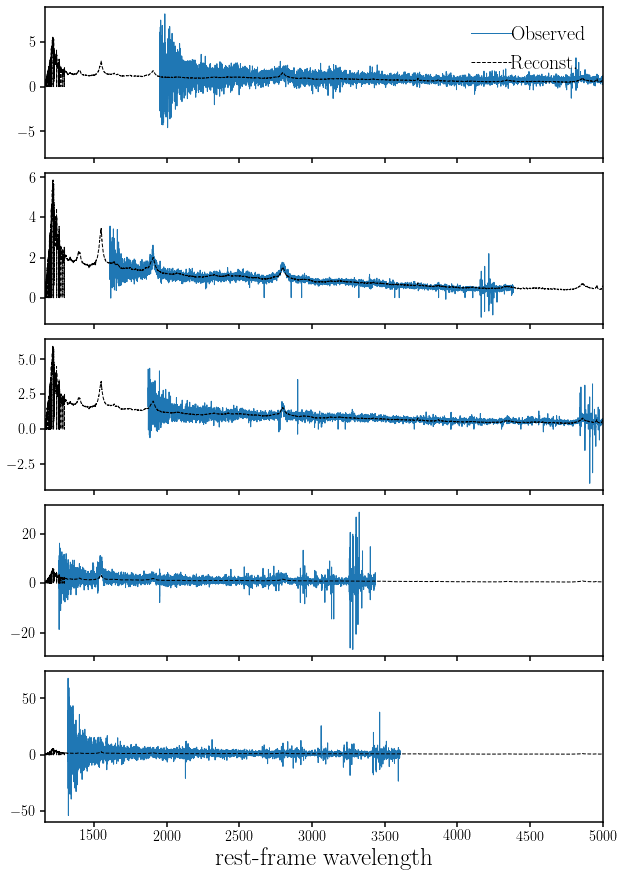

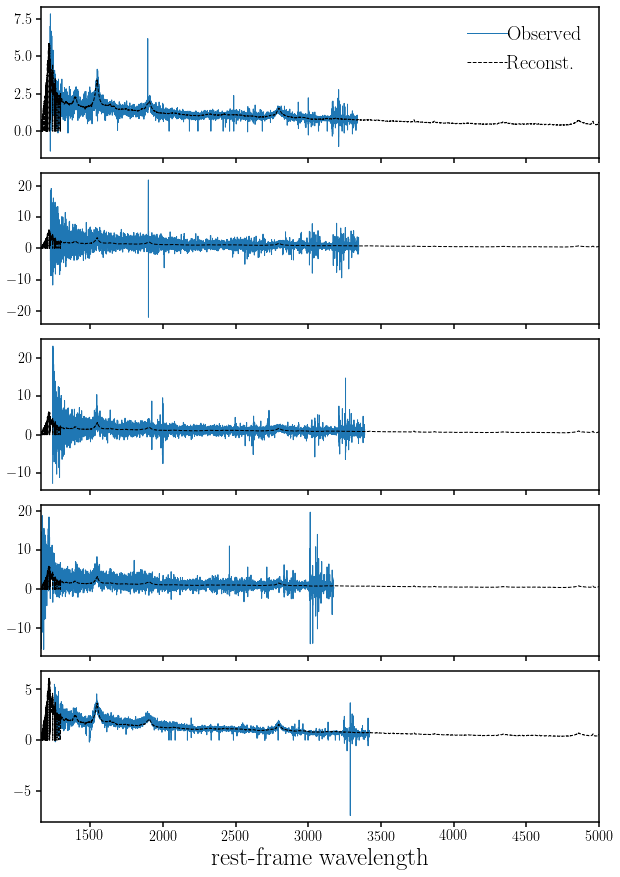

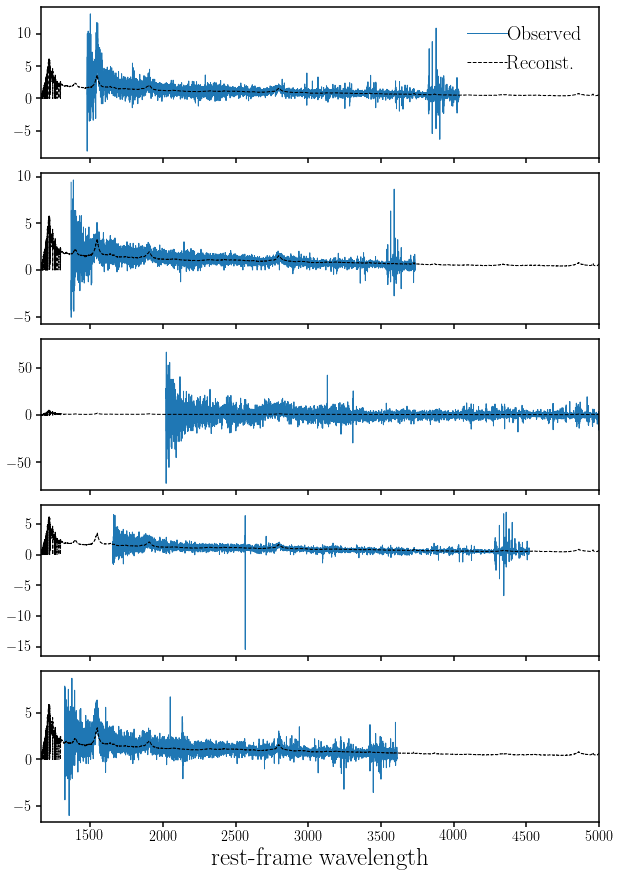

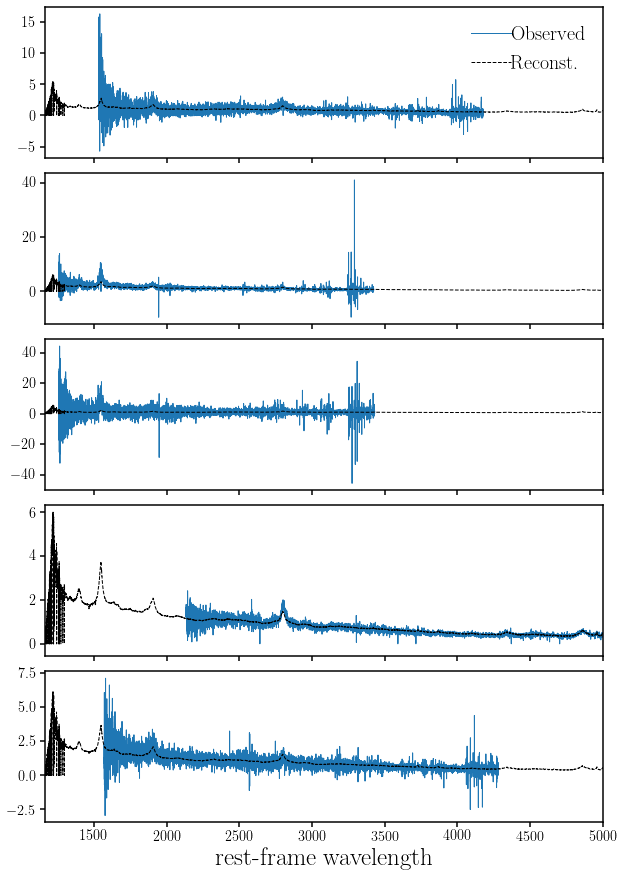

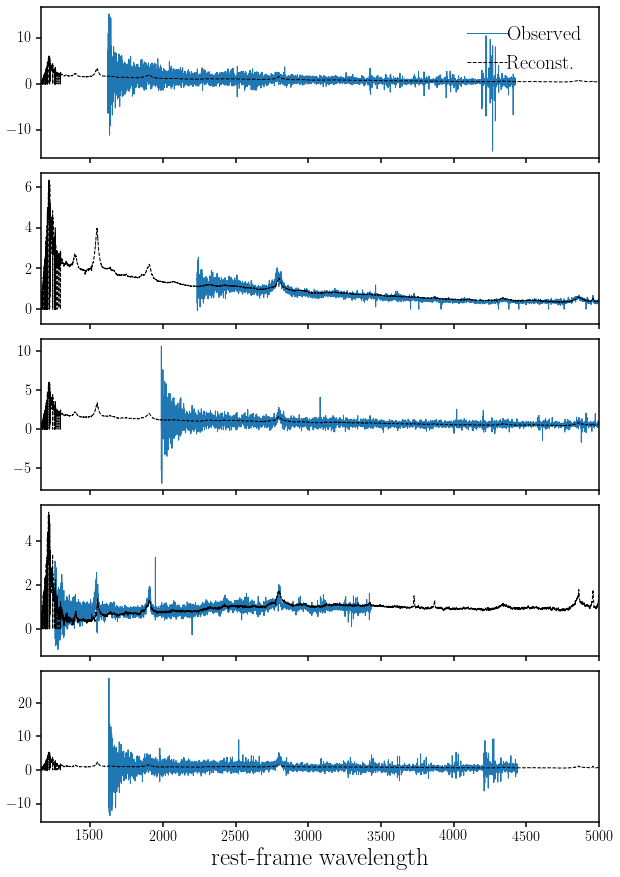

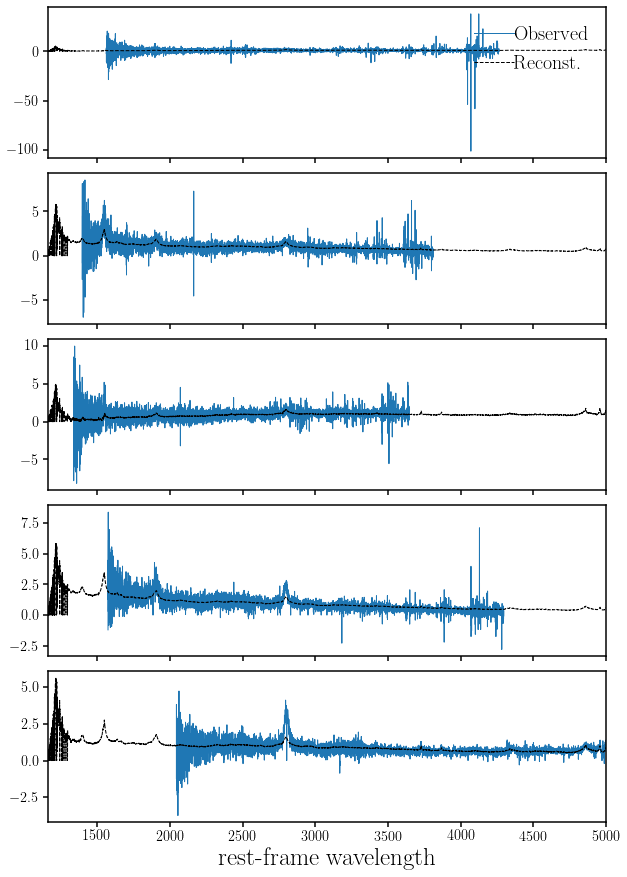

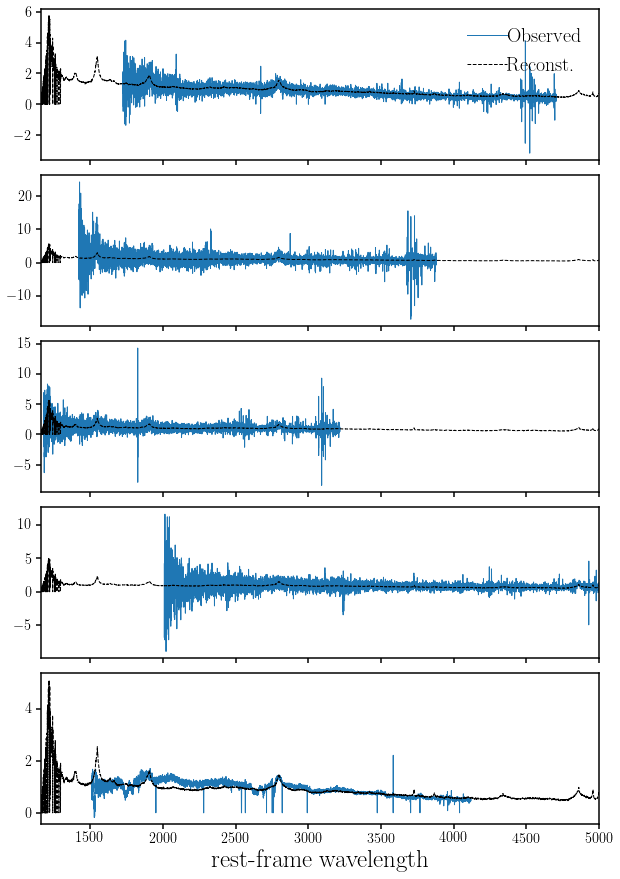

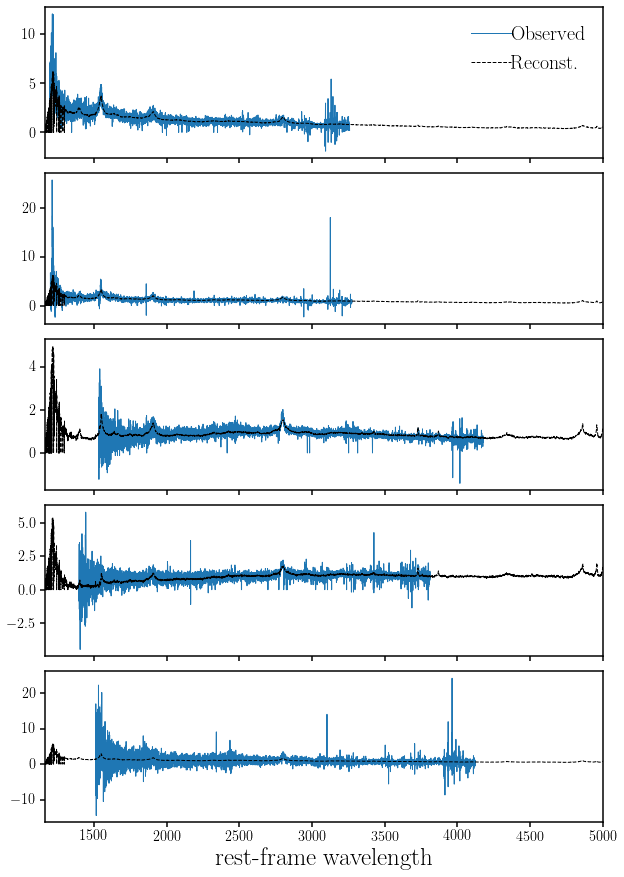

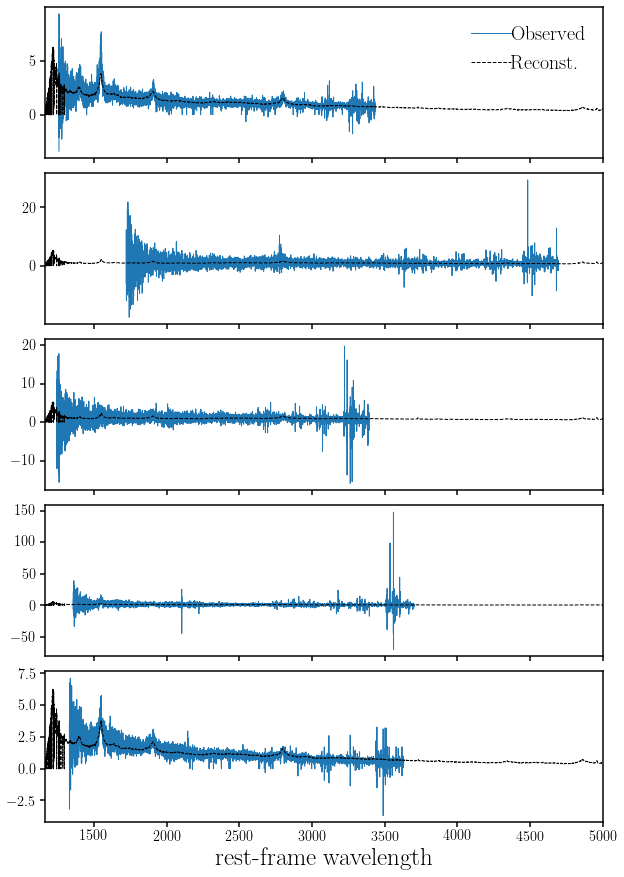

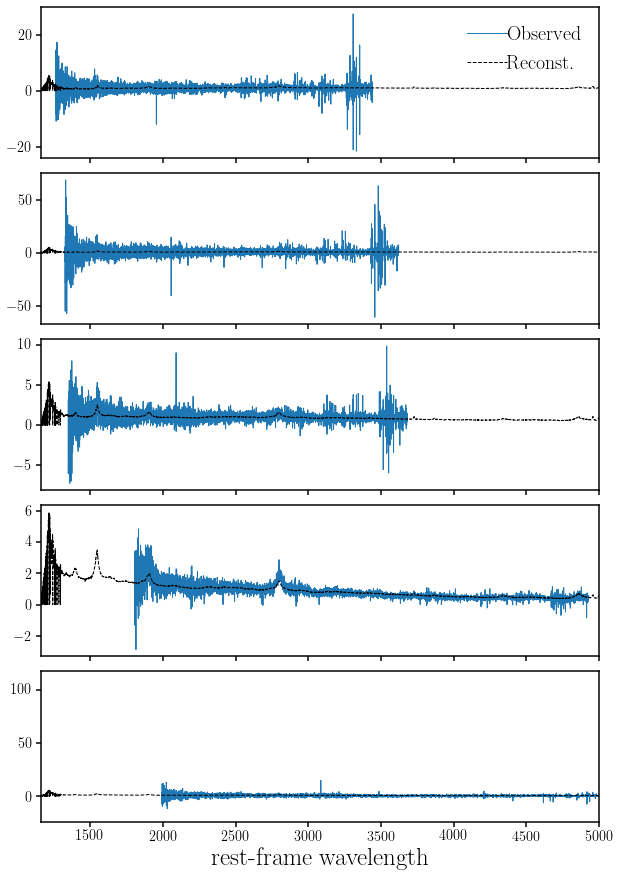

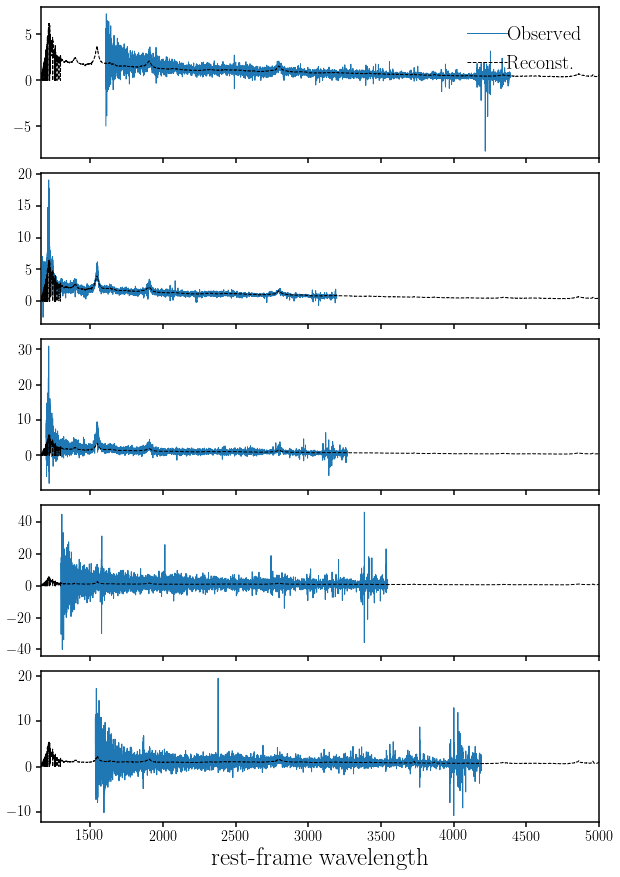

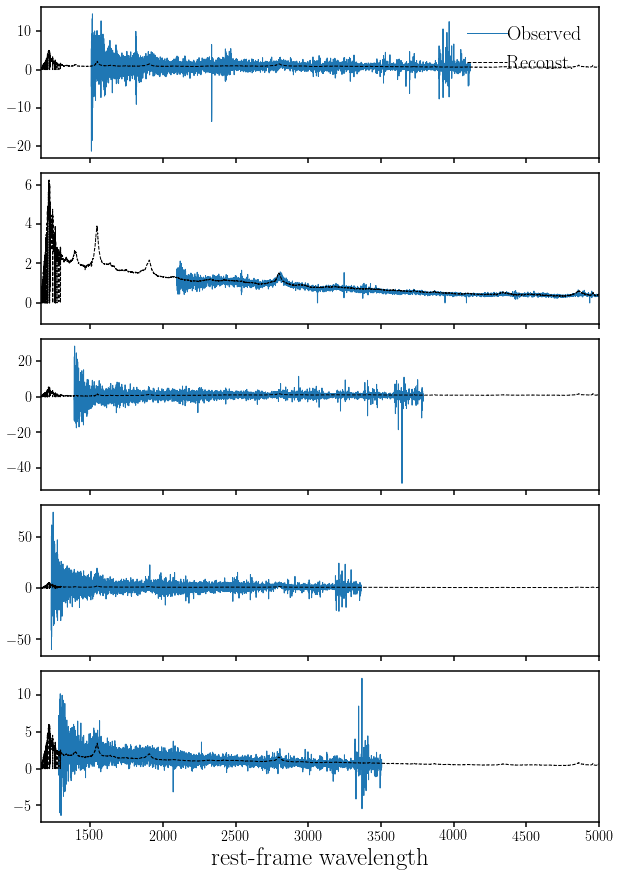

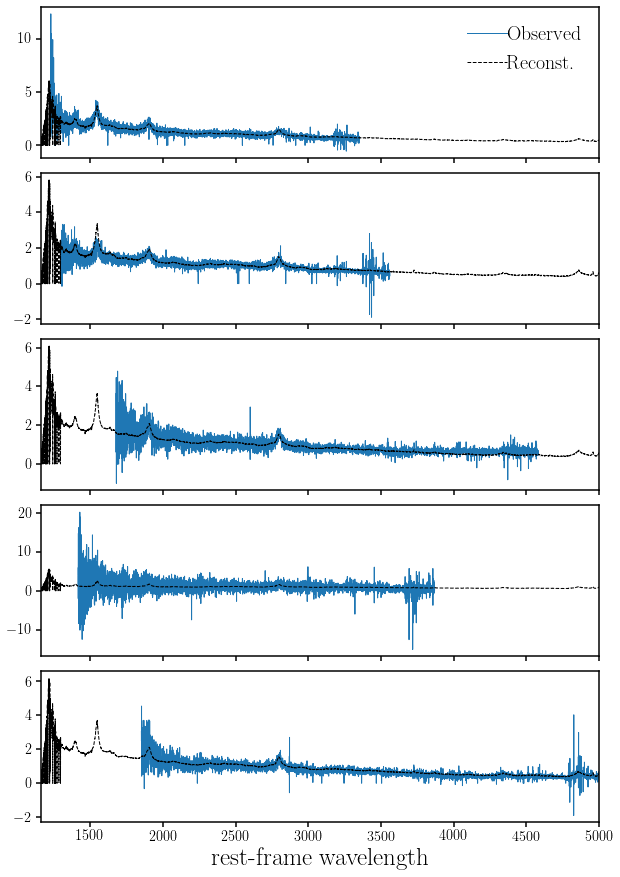

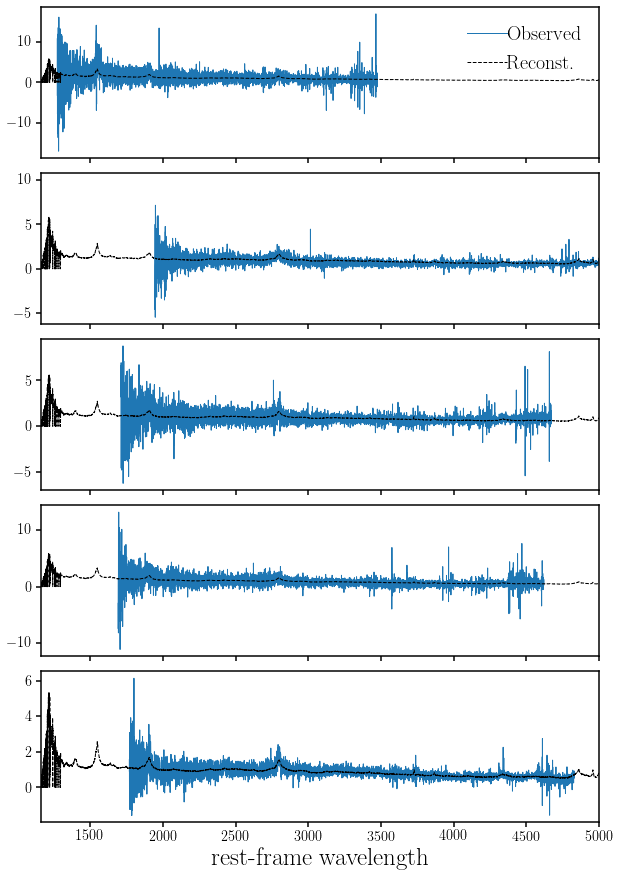

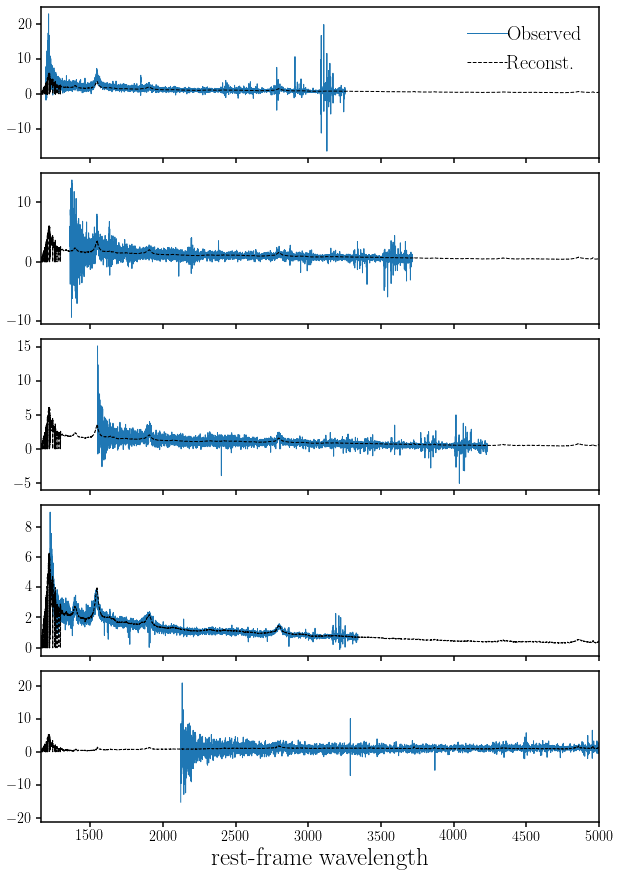

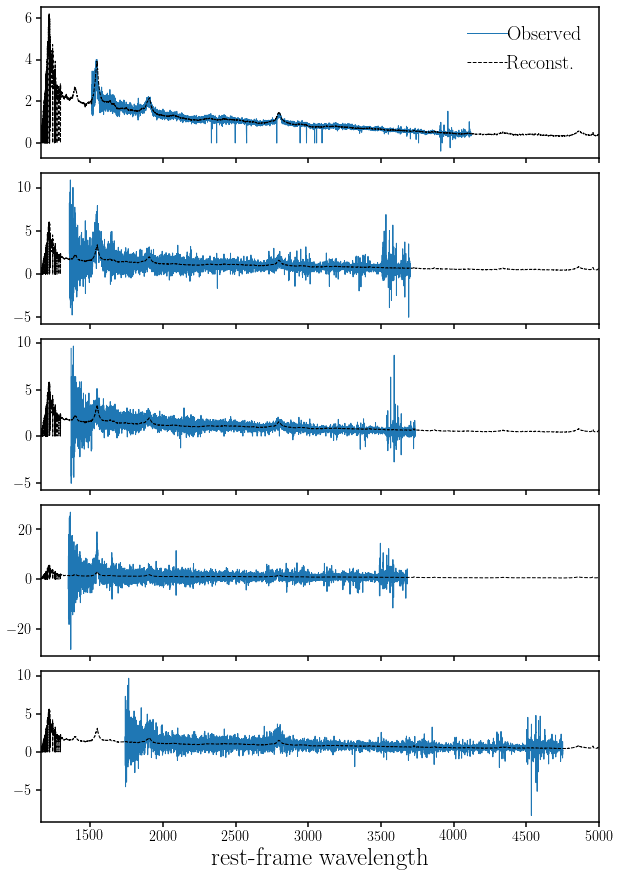

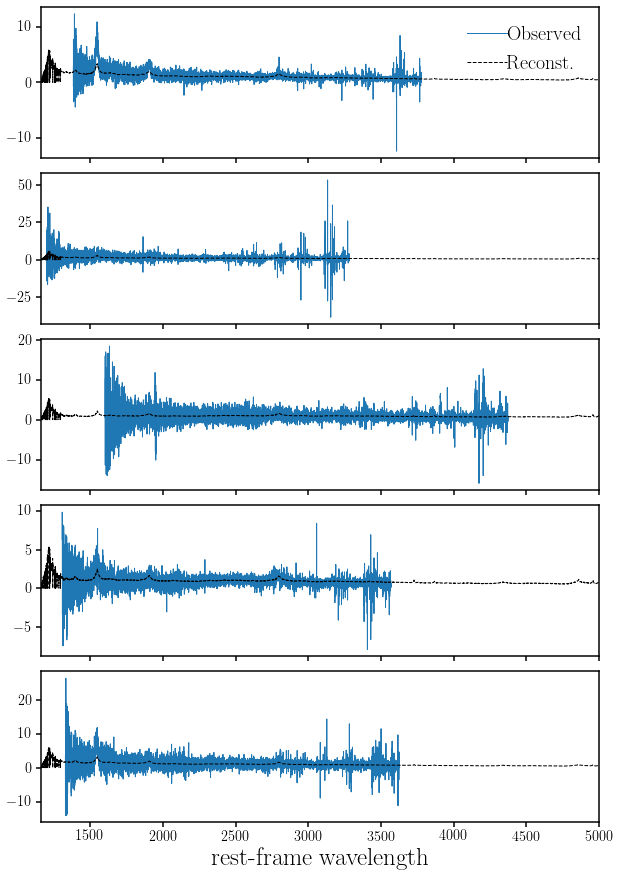

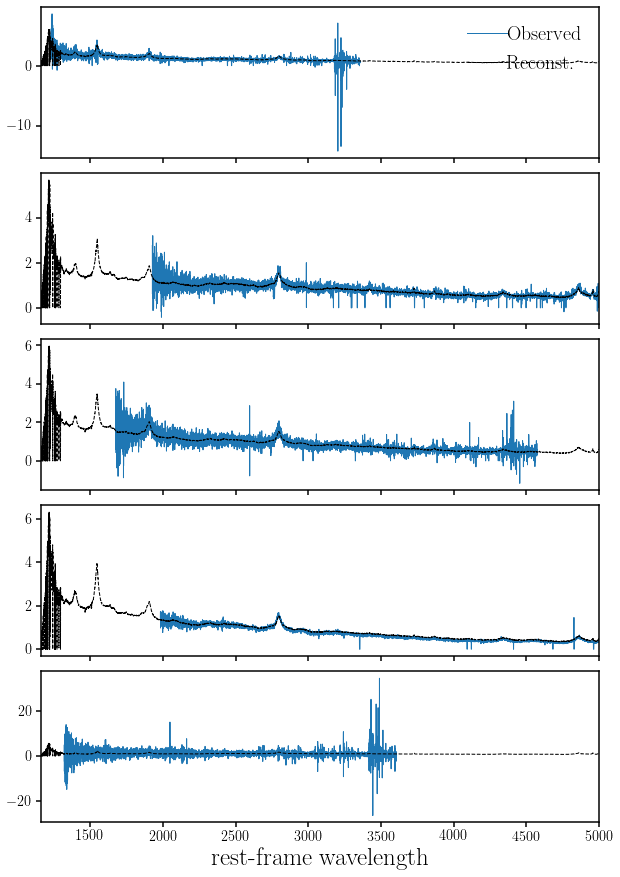

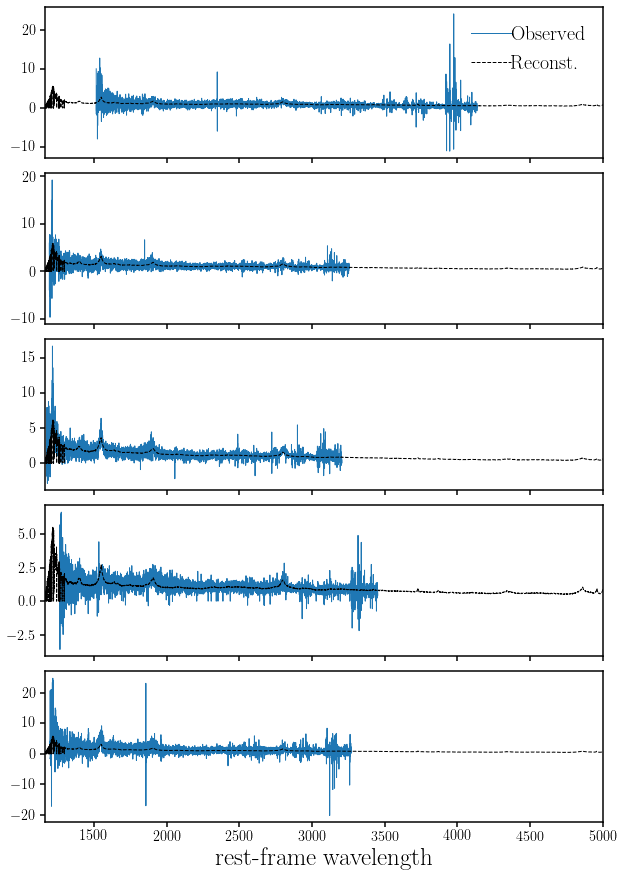

In [32]:
with torch.no_grad():
    models[0].eval()
    instruments[0].eval()
    
    for k, batch in enumerate(validloaders[0]):
        spec, w, z = batch

        s = models[0].encode(batch[0])
        spec_rest = models[0].decode(s)
    
        fig = plt.figure(figsize=(10,15))
        for ii, igal in enumerate(np.random.choice(np.arange(len(spec)), size=5, replace=False)): 
            sub = fig.add_subplot(5,1,ii+1)
            sub.plot(models[0].wave_obs/(1 + z[igal]), spec[igal], lw=1, label='Observed')
            sub.plot(models[0].wave_rest, spec_rest[igal], color='k', lw=1, ls='--', label='Reconst.')
            sub.set_xlim(models[0].wave_rest[0], 5e3)
            if ii < 4: sub.set_xticklabels([])
            if ii == 0: sub.legend(loc='upper right', fontsize=20, handletextpad=0)
        sub.set_xlabel("rest-frame wavelength", fontsize=25)
        fig.subplots_adjust(hspace=0.1)
        plt.show()
        #s, spec_rest, spec_recon = models[0]._forward(spec, instrument=instruments[0], z=z, weights=w)
        #print(s)
        #print(spec_rest)
        #print(spec_recon)
        #break